# TP05 - Exercice 3 : Rééquilibrage des données et validation croisée

### Noms eleve
Ethan TOMASO et julien TREMONT-RAIMI


**Objectifs :**
- Comparer différentes stratégies de rééquilibrage (Sans rééquilibrage, RandomOverSampler, SMOTE, RandomUnderSampler)
- Analyser leur impact sur les performances et la robustesse du modèle
- Évaluer avec validation croisée stratifiée

In [1]:
# Imports nécessaires
import numpy as np
import pandas as pd
import time
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Chargement et création d'un déséquilibre artificiel

In [2]:
# 1. Chargement du dataset breast_cancer
# Ce dataset contient des caractéristiques de tumeurs du sein pour prédire si elles sont malignes ou bénignes
X, y = load_breast_cancer(return_X_y=True)
print("=== Dataset Breast Cancer ===")
print(f"Nombre d'échantillons : {len(X)}")
print(f"Nombre de features : {X.shape[1]}")
print("\nDistribution originale des classes:")
print(Counter(y))
print("  Classe 0 : Maligne")
print("  Classe 1 : Bénigne")

# Création d'un déséquilibre artificiel pour mieux illustrer l'effet des techniques de rééquilibrage
# On garde tous les échantillons de la classe majoritaire (0) et seulement 40% de la classe minoritaire (1)
idx_majority = np.where(y == 0)[0]
idx_minority = np.where(y == 1)[0]

# Sous-échantillonnage aléatoire de la classe minoritaire
np.random.seed(42)
idx_minority_sampled = np.random.choice(idx_minority, size=int(0.4 * len(idx_minority)), replace=False)

# Reconstruction du dataset avec déséquilibre
X = np.vstack((X[idx_majority], X[idx_minority_sampled]))
y = np.hstack((y[idx_majority], y[idx_minority_sampled]))

print("\nDistribution APRÈS création du déséquilibre artificiel:")
class_counts = Counter(y)
print(class_counts)
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"Ratio de déséquilibre : {imbalance_ratio:.2f}:1")
print(f"  → La classe 0 (maligne) est {imbalance_ratio:.1f}x plus représentée que la classe 1 (bénigne)")

=== Dataset Breast Cancer ===
Nombre d'échantillons : 569
Nombre de features : 30

Distribution originale des classes:
Counter({1: 357, 0: 212})
  Classe 0 : Maligne
  Classe 1 : Bénigne

Distribution APRÈS création du déséquilibre artificiel:
Counter({0: 212, 1: 142})
Ratio de déséquilibre : 1.49:1
  → La classe 0 (maligne) est 1.5x plus représentée que la classe 1 (bénigne)


In [3]:
# Division train/test avec stratification (30% pour le test comme spécifié dans le code original)
# La stratification garantit que les proportions de classes sont maintenues dans train et test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\n=== Division Train/Test ===")
print(f"Train set : {len(X_train)} échantillons")
print(f"  - Distribution : {Counter(y_train)}")
print(f"Test set : {len(X_test)} échantillons")
print(f"  - Distribution : {Counter(y_test)}")


=== Division Train/Test ===
Train set : 247 échantillons
  - Distribution : Counter({0: 148, 1: 99})
Test set : 107 échantillons
  - Distribution : Counter({0: 64, 1: 43})


## 2. Vérification du problème de déséquilibre

In [ ]:
# 2. Vérification du problème de déséquilibre et calcul du ratio
print("\n" + "="*70)
print("VÉRIFICATION DU DÉSÉQUILIBRE DES CLASSES")
print("="*70)

train_counts = Counter(y_train)
n_majority = train_counts[0]
n_minority = train_counts[1]
ratio = n_majority / n_minority

print(f"\nDistribution dans le train set :")
print(f"  Classe 0 (majoritaire) : {n_majority} échantillons ({n_majority/len(y_train)*100:.1f}%)")
print(f"  Classe 1 (minoritaire) : {n_minority} échantillons ({n_minority/len(y_train)*100:.1f}%)")
print(f"\nRatio d'imbalance : {ratio:.2f}:1")
print(f"\nInterprétation : Pour chaque échantillon de la classe minoritaire (1),")
print(f"                 il y a {ratio:.1f} échantillons de la classe majoritaire (0).")
print(f"\nCe déséquilibre peut biaiser le modèle vers la classe majoritaire !")


VÉRIFICATION DU DÉSÉQUILIBRE DES CLASSES

Distribution dans le train set :
  Classe 0 (majoritaire) : 148 échantillons (59.9%)
  Classe 1 (minoritaire) : 99 échantillons (40.1%)

Ratio d'imbalance : 1.49:1

Interprétation : Pour chaque échantillon de la classe minoritaire (1),
                 il y a 1.5 échantillons de la classe majoritaire (0).

⚠️  Ce déséquilibre peut biaiser le modèle vers la classe majoritaire !


## 3. Définition des stratégies de rééquilibrage

In [6]:
# 3. Expérimentation avec différentes méthodes de gestion du déséquilibre
print("\n" + "="*70)
print("STRATÉGIES DE RÉÉQUILIBRAGE")
print("="*70)

# Définition des différentes stratégies à tester
samplers = {
    "No Rebalancing": None,  # Baseline : pas de rééquilibrage
    "Random OverSampling": RandomOverSampler(random_state=42),  # Duplication aléatoire de la classe minoritaire
    "SMOTE": SMOTE(random_state=42),  # Génération d'échantillons synthétiques
    "Random UnderSampling": RandomUnderSampler(random_state=42)  # Réduction de la classe majoritaire
}

print("\nStratégies testées :")
print("  1. No Rebalancing (Baseline)")
print("     → Aucune modification des données")
print("     → Permet d'établir une référence de performance")
print("\n  2. Random OverSampling")
print("     → Duplique aléatoirement des échantillons de la classe minoritaire")
print("     → Avantage : simple et préserve tous les échantillons originaux")
print("     → Inconvénient : risque de surapprentissage (overfitting) sur les échantillons dupliqués")
print("\n  3. SMOTE (Synthetic Minority Over-sampling TEchnique)")
print("     → Génère des échantillons synthétiques par interpolation entre k-plus proches voisins")
print("     → Avantage : crée de nouvelles données, plus de variabilité")
print("     → Inconvénient : peut créer des échantillons dans des zones de chevauchement des classes")
print("\n  4. Random UnderSampling")
print("     → Supprime aléatoirement des échantillons de la classe majoritaire")
print("     → Avantage : réduit la taille du dataset (entraînement plus rapide)")
print("     → Inconvénient : perte d'information potentiellement importante")


STRATÉGIES DE RÉÉQUILIBRAGE

Stratégies testées :
  1. No Rebalancing (Baseline)
     → Aucune modification des données
     → Permet d'établir une référence de performance

  2. Random OverSampling
     → Duplique aléatoirement des échantillons de la classe minoritaire
     → Avantage : simple et préserve tous les échantillons originaux
     → Inconvénient : risque de surapprentissage (overfitting) sur les échantillons dupliqués

  3. SMOTE (Synthetic Minority Over-sampling TEchnique)
     → Génère des échantillons synthétiques par interpolation entre k-plus proches voisins
     → Avantage : crée de nouvelles données, plus de variabilité
     → Inconvénient : peut créer des échantillons dans des zones de chevauchement des classes

  4. Random UnderSampling
     → Supprime aléatoirement des échantillons de la classe majoritaire
     → Avantage : réduit la taille du dataset (entraînement plus rapide)
     → Inconvénient : perte d'information potentiellement importante


## 4. Entraînement et évaluation avec validation croisée

In [7]:
# 4. Configuration de la validation croisée stratifiée
# StratifiedKFold maintient les proportions de classes dans chaque fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n=== Configuration de la validation croisée ===")
print(f"Méthode : StratifiedKFold avec {cv.get_n_splits()} folds")
print("Pourquoi StratifiedKFold ?")
print("  → Garantit que chaque fold conserve les proportions de classes du dataset original")
print("  → Crucial pour des données déséquilibrées afin d'éviter des folds sans échantillons minoritaires")


=== Configuration de la validation croisée ===
Méthode : StratifiedKFold avec 5 folds
Pourquoi StratifiedKFold ?
  → Garantit que chaque fold conserve les proportions de classes du dataset original
  → Crucial pour des données déséquilibrées afin d'éviter des folds sans échantillons minoritaires


In [8]:
# 5. Entraînement et évaluation pour chaque stratégie
print("\n" + "="*70)
print("ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES")
print("="*70)

results = []
conf_matrices = {}

for name, sampler in samplers.items():
    print(f"\n{'='*70}")
    print(f"Stratégie : {name}")
    print(f"{'='*70}")
    
    # Application du rééchantillonnage si nécessaire
    X_res, y_res = (X_train, y_train)
    if sampler:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    
    res_counts = Counter(y_res)
    print(f"Distribution des classes après rééchantillonnage : {res_counts}")
    if res_counts[0] != res_counts[1]:
        print(f"  Ratio : {res_counts[0]/res_counts[1]:.2f}:1")
    else:
        print("  Ratio : 1:1 (parfaitement équilibré)")
    
    # Initialisation du classificateur Random Forest
    # Random Forest est robuste et performant pour la classification binaire
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Validation croisée
    f1_scores, auc_scores, training_times = [], [], []
    conf_sum = np.zeros((2, 2))
    
    print("\nValidation croisée (5 folds) :")
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_res, y_res)):
        # Division des données pour ce fold
        X_tr, X_val = X_res[train_idx], X_res[val_idx]
        y_tr, y_val = y_res[train_idx], y_res[val_idx]
        
        # Entraînement avec mesure du temps
        start_time = time.time()
        model.fit(X_tr, y_tr)
        training_time = time.time() - start_time
        training_times.append(training_time)
        
        # Prédictions
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
        
        # Calcul des métriques
        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba)
        f1_scores.append(f1)
        auc_scores.append(auc)
        
        # Accumulation des matrices de confusion
        conf_sum += confusion_matrix(y_val, y_pred)
        
        print(f"  Fold {fold_idx+1}: F1={f1:.3f}, AUC={auc:.3f}, Time={training_time:.3f}s")
    
    # Calcul des moyennes et écarts-types
    conf_avg = conf_sum / cv.get_n_splits()
    conf_matrices[name] = conf_avg
    
    print(f"\nRésultats moyens :")
    print(f"  F1-Score    : {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
    print(f"  AUC         : {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
    print(f"  Temps moyen : {np.mean(training_times):.3f} ± {np.std(training_times):.3f} secondes")
    
    # Stockage des résultats
    results.append({
        'Method': name,
        'F1_mean': np.mean(f1_scores),
        'F1_std': np.std(f1_scores),
        'AUC_mean': np.mean(auc_scores),
        'AUC_std': np.std(auc_scores),
        'Time_mean': np.mean(training_times),
        'Time_std': np.std(training_times),
        'Dataset_size': len(X_res)
    })


ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES

Stratégie : No Rebalancing
Distribution des classes après rééchantillonnage : Counter({0: 148, 1: 99})
  Ratio : 1.49:1

Validation croisée (5 folds) :
  Fold 1: F1=0.872, AUC=0.955, Time=0.100s
  Fold 2: F1=0.923, AUC=0.992, Time=0.137s
  Fold 3: F1=0.974, AUC=1.000, Time=0.117s
  Fold 4: F1=0.952, AUC=1.000, Time=0.123s
  Fold 5: F1=0.947, AUC=0.969, Time=0.098s

Résultats moyens :
  F1-Score    : 0.934 ± 0.035
  AUC         : 0.983 ± 0.018
  Temps moyen : 0.115 ± 0.014 secondes

Stratégie : Random OverSampling
Distribution des classes après rééchantillonnage : Counter({1: 148, 0: 148})
  Ratio : 1:1 (parfaitement équilibré)

Validation croisée (5 folds) :
  Fold 1: F1=0.983, AUC=0.999, Time=0.099s
  Fold 2: F1=0.947, AUC=0.995, Time=0.119s
  Fold 3: F1=0.952, AUC=0.961, Time=0.121s
  Fold 4: F1=0.967, AUC=0.999, Time=0.115s
  Fold 5: F1=0.900, AUC=0.982, Time=0.110s

Résultats moyens :
  F1-Score    : 0.950 ± 0.028
  AUC         : 0.987 ± 0.0

## 5. Compilation et affichage des résultats

In [9]:
# 6. Compilation et affichage des résultats
print("\n" + "="*70)
print("TABLEAU RÉCAPITULATIF DES RÉSULTATS")
print("="*70)

results_df = pd.DataFrame(results)
print("\n", results_df[['Method', 'F1_mean', 'F1_std', 'AUC_mean', 'AUC_std', 'Time_mean', 'Dataset_size']].round(3))


TABLEAU RÉCAPITULATIF DES RÉSULTATS

                  Method  F1_mean  F1_std  AUC_mean  AUC_std  Time_mean  \
0        No Rebalancing    0.934   0.035     0.983    0.018      0.115   
1   Random OverSampling    0.950   0.028     0.987    0.015      0.113   
2                 SMOTE    0.922   0.048     0.987    0.013      0.112   
3  Random UnderSampling    0.930   0.051     0.980    0.027      0.123   

   Dataset_size  
0           247  
1           296  
2           296  
3           198  


## 6. Discussion des compromis

In [10]:
# 7. Discussion des compromis
print("\n" + "="*70)
print("DISCUSSION DES COMPROMIS ENTRE PRÉCISION, RECALL ET OVERFITTING")
print("="*70)

print("""
1. ANALYSE DES PERFORMANCES (F1-Score et AUC) :

   - No Rebalancing (Baseline) :
     Le modèle tend à favoriser la classe majoritaire pour maximiser l'accuracy.
     → Peut avoir une bonne accuracy globale mais un faible recall sur la classe minoritaire.
     → Adapté si les coûts d'erreur sont équilibrés entre les classes.

   - Random OverSampling :
     Améliore généralement le recall en donnant plus de poids à la classe minoritaire.
     → RISQUE : Surapprentissage (overfitting) car le modèle voit plusieurs fois les mêmes échantillons.
     → Le modèle peut mémoriser les échantillons dupliqués plutôt que généraliser.
     → Bonne performance en training mais peut être moins robuste en test.

   - SMOTE :
     Génère des échantillons synthétiques → plus de variabilité que le simple oversampling.
     → AVANTAGE : Moins de risque d'overfitting que RandomOverSampler.
     → RISQUE : Peut créer des échantillons synthétiques dans des zones d'incertitude
                 (chevauchement des classes) → bruit potentiel.
     → Généralement meilleur compromis entre performance et robustesse.

   - Random UnderSampling :
     Supprime des échantillons de la classe majoritaire → dataset plus petit.
     → AVANTAGE : Entraînement plus rapide (moins de données).
     → RISQUE : Perte d'information importante → sous-apprentissage (underfitting) possible.
     → Peut réduire la capacité du modèle à bien généraliser si trop d'échantillons
        informatifs de la classe majoritaire sont supprimés.

2. COMPROMIS PRÉCISION/RECALL :

   - Baseline : Privilégie la précision sur la classe majoritaire au détriment du recall
                sur la classe minoritaire.

   - Techniques de rééquilibrage : Améliorent le recall sur la classe minoritaire
                                    mais peuvent réduire légèrement la précision globale.

   - F1-Score : Mesure le compromis entre précision et recall.
                Une amélioration du F1 indique un meilleur équilibre.

3. COMPROMIS PERFORMANCE/TEMPS D'ENTRAÎNEMENT :

   - Random UnderSampling : Le plus rapide (dataset réduit) mais potentiellement
                             moins performant.

   - Random OverSampling et SMOTE : Plus lents (dataset augmenté) mais généralement
                                     plus performants.

   - Baseline : Temps intermédiaire, dépend de la taille originale du dataset.

4. RECOMMANDATIONS :

   - Si les ressources computationnelles sont limitées → Random UnderSampling.
   - Si la performance est prioritaire → SMOTE (meilleur compromis).
   - Si le dataset est très petit → Random OverSampling (préserve tous les échantillons).
   - Si les coûts d'erreur entre classes sont équilibrés → Baseline peut suffire.
""")

# Analyse comparative des résultats obtenus
print("\n" + "-"*70)
print("OBSERVATIONS SUR NOS RÉSULTATS :")
print("-"*70)

best_f1 = results_df.loc[results_df['F1_mean'].idxmax()]
best_auc = results_df.loc[results_df['AUC_mean'].idxmax()]
fastest = results_df.loc[results_df['Time_mean'].idxmin()]

print(f"\nMeilleur F1-Score : {best_f1['Method']} ({best_f1['F1_mean']:.3f})")
print(f"Meilleur AUC      : {best_auc['Method']} ({best_auc['AUC_mean']:.3f})")
print(f"Plus rapide       : {fastest['Method']} ({fastest['Time_mean']:.3f}s)")

print("\nCONCLUSION :")
if best_f1['Method'] == best_auc['Method']:
    print(f"  → {best_f1['Method']} offre les meilleures performances (F1 et AUC).")
else:
    print(f"  → {best_f1['Method']} est meilleur pour le F1-Score.")
    print(f"  → {best_auc['Method']} est meilleur pour l'AUC.")

if fastest['Method'] != best_f1['Method']:
    print(f"  → Mais {fastest['Method']} est significativement plus rapide.")
    print(f"    Compromis à considérer selon les contraintes du projet.")


DISCUSSION DES COMPROMIS ENTRE PRÉCISION, RECALL ET OVERFITTING

1. ANALYSE DES PERFORMANCES (F1-Score et AUC) :

   - No Rebalancing (Baseline) :
     Le modèle tend à favoriser la classe majoritaire pour maximiser l'accuracy.
     → Peut avoir une bonne accuracy globale mais un faible recall sur la classe minoritaire.
     → Adapté si les coûts d'erreur sont équilibrés entre les classes.

   - Random OverSampling :
     Améliore généralement le recall en donnant plus de poids à la classe minoritaire.
     → RISQUE : Surapprentissage (overfitting) car le modèle voit plusieurs fois les mêmes échantillons.
     → Le modèle peut mémoriser les échantillons dupliqués plutôt que généraliser.
     → Bonne performance en training mais peut être moins robuste en test.

   - SMOTE :
     Génère des échantillons synthétiques → plus de variabilité que le simple oversampling.
     → AVANTAGE : Moins de risque d'overfitting que RandomOverSampler.
     → RISQUE : Peut créer des échantillons synthét

## 7. Visualisations comparatives


VISUALISATIONS


C:\Users\j.tremont\AppData\Local\Temp\ipykernel_30472\979088821.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results_df['Method'], rotation=20, ha='right')
C:\Users\j.tremont\AppData\Local\Temp\ipykernel_30472\979088821.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results_df['Method'], rotation=20, ha='right')
C:\Users\j.tremont\AppData\Local\Temp\ipykernel_30472\979088821.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results_df['Method'], rotation=20, ha='right')


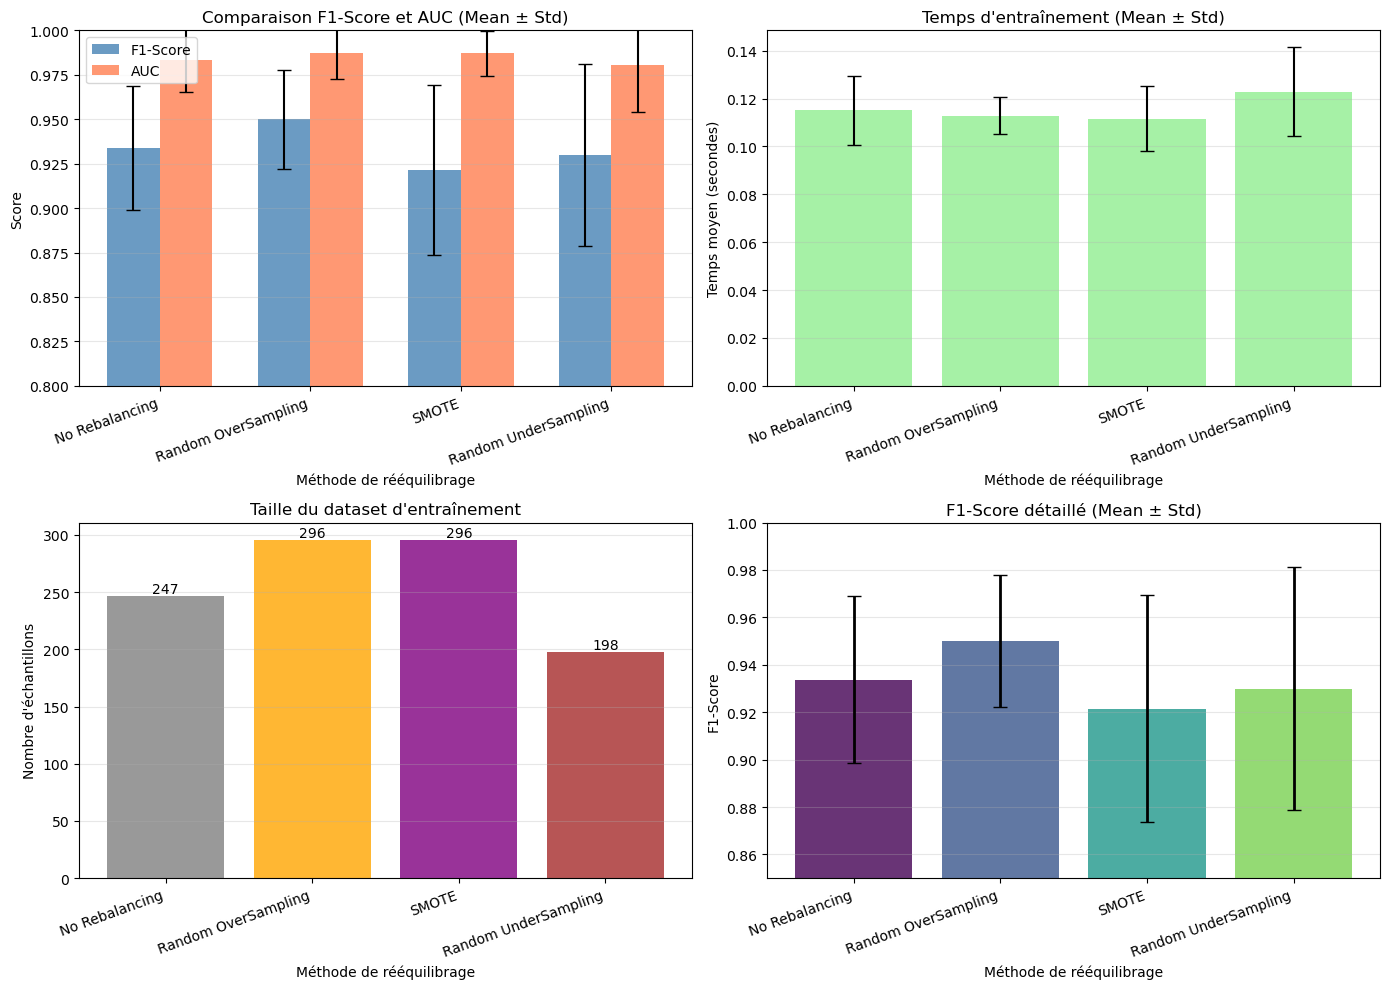

In [11]:
# 8. Visualisation : Graphique en barres comparatif des F1-scores et AUC
print("\n" + "="*70)
print("VISUALISATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (a) Comparaison F1-Score et AUC
ax = axes[0, 0]
x = np.arange(len(results_df))
width = 0.35
bars1 = ax.bar(x - width/2, results_df['F1_mean'], width, label='F1-Score', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, results_df['AUC_mean'], width, label='AUC', alpha=0.8, color='coral')
ax.errorbar(x - width/2, results_df['F1_mean'], yerr=results_df['F1_std'], 
            fmt='none', ecolor='black', capsize=5)
ax.errorbar(x + width/2, results_df['AUC_mean'], yerr=results_df['AUC_std'], 
            fmt='none', ecolor='black', capsize=5)
ax.set_xlabel('Méthode de rééquilibrage')
ax.set_ylabel('Score')
ax.set_title('Comparaison F1-Score et AUC (Mean ± Std)')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Method'], rotation=20, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.8, 1.0])

# (b) Temps d'entraînement
ax = axes[0, 1]
bars = ax.bar(results_df['Method'], results_df['Time_mean'], alpha=0.8, color='lightgreen')
ax.errorbar(x, results_df['Time_mean'], yerr=results_df['Time_std'], 
            fmt='none', ecolor='black', capsize=5)
ax.set_xlabel('Méthode de rééquilibrage')
ax.set_ylabel('Temps moyen (secondes)')
ax.set_title('Temps d\'entraînement (Mean ± Std)')
ax.set_xticklabels(results_df['Method'], rotation=20, ha='right')
ax.grid(axis='y', alpha=0.3)

# (c) Taille du dataset après rééchantillonnage
ax = axes[1, 0]
colors_dataset = ['gray', 'orange', 'purple', 'brown']
bars = ax.bar(results_df['Method'], results_df['Dataset_size'], alpha=0.8, color=colors_dataset)
ax.set_xlabel('Méthode de rééquilibrage')
ax.set_ylabel('Nombre d\'échantillons')
ax.set_title('Taille du dataset d\'entraînement')
ax.set_xticklabels(results_df['Method'], rotation=20, ha='right')
ax.grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom')

# (d) F1-Score avec barres d'erreur (détaillé)
ax = axes[1, 1]
colors_f1 = plt.cm.viridis(np.linspace(0, 0.8, len(results_df)))
bars = ax.bar(results_df['Method'], results_df['F1_mean'], alpha=0.8, color=colors_f1)
ax.errorbar(x, results_df['F1_mean'], yerr=results_df['F1_std'], 
            fmt='none', ecolor='black', capsize=5, linewidth=2)
ax.set_xlabel('Méthode de rééquilibrage')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score détaillé (Mean ± Std)')
ax.set_xticklabels(results_df['Method'], rotation=20, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.85, 1.0])

plt.tight_layout()
plt.show()

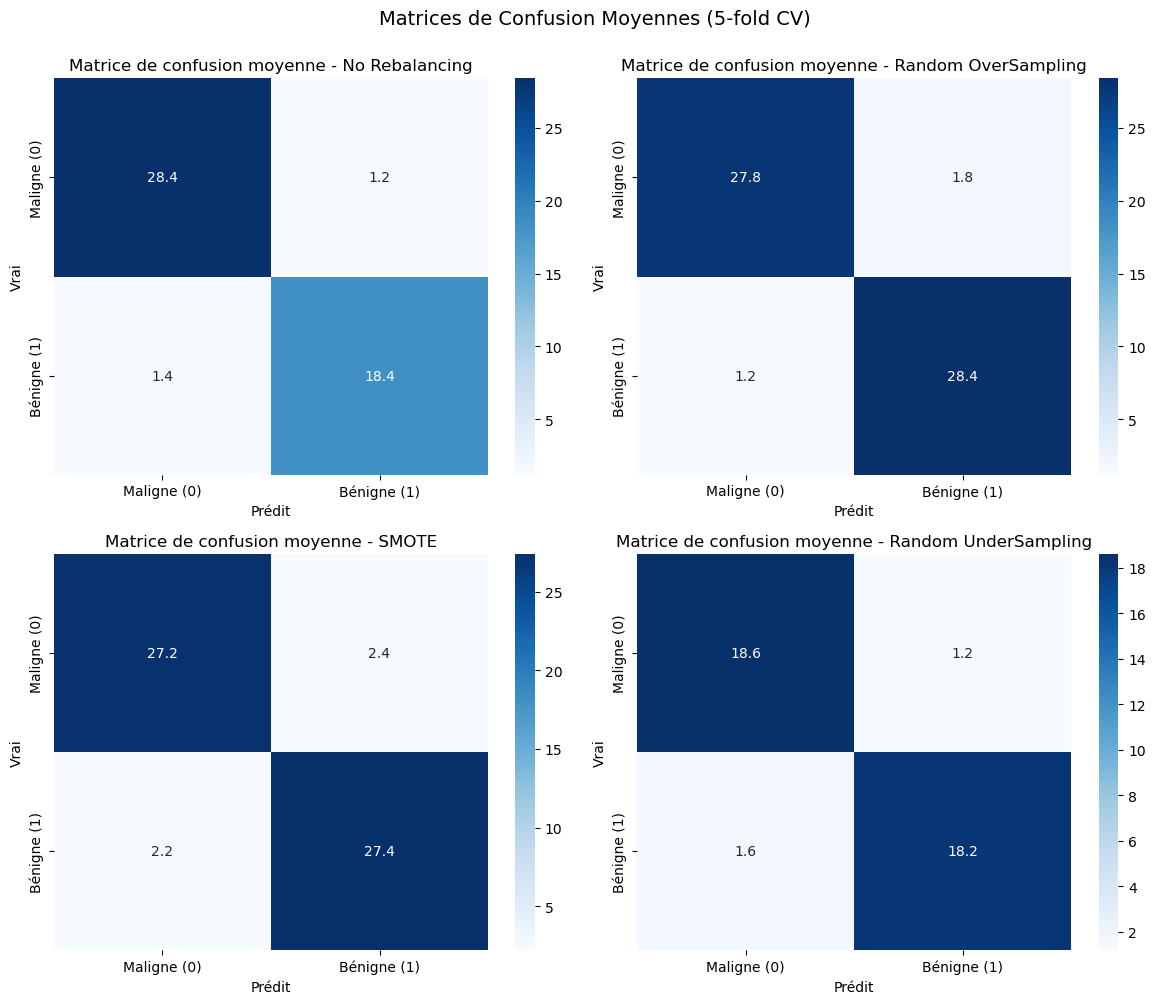


EXERCICE 3 TERMINÉ


In [12]:
# 9. Visualisation des matrices de confusion moyennes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", ax=axes[i],
                xticklabels=['Maligne (0)', 'Bénigne (1)'],
                yticklabels=['Maligne (0)', 'Bénigne (1)'])
    axes[i].set_title(f'Matrice de confusion moyenne - {name}')
    axes[i].set_xlabel('Prédit')
    axes[i].set_ylabel('Vrai')

plt.suptitle('Matrices de Confusion Moyennes (5-fold CV)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("EXERCICE 3 TERMINÉ")
print("="*70)